In [22]:
window_size = 1001

## Normalized mean and normalized standard deviation of singleton count distribution

Consider all windows of a fixed size  containing $m$ ALT alleles
(c.f., [here](https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb)). 
Let $\hat{p}(m)$ denote the Maximum Likelihood Estimate of the 
probability that a randomly chosen ALT allele is a singleton 
(appearing in just one chromosome). Then, 
under a variety of assumptions (e.g., ALT allele frequencies are independent), 
we have

$$ 
\hat{p}(m) = \frac{\langle K \, | \, M=m\rangle}{ m },  
$$

where $\langle K \, | \, M=m\rangle$ is the mean of the singleton count distribution: 

$$
\langle K \, | \, M=m\rangle = \frac{\sum_{k=0}^{m} k w_k}{ \sum_{k=0}^{m} w_k}. 
$$ 

Here, $w_k$ is the number of windows in which $k$ of the $m$ ALT alleles are singletons. 

Since the singleton count distribution is approximately binomial (verified below),
it is natural to normalize the standard deviation of the singleton-count distribution
as follows: 

$$
\frac{\mbox{std}(K \, | \, M=m)}{\sqrt{m}}
$$ 

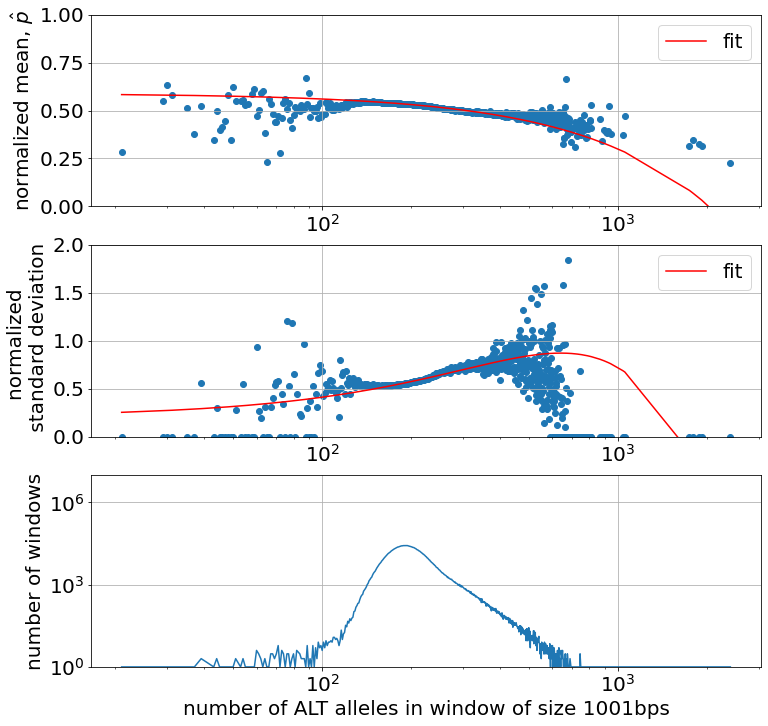

In [23]:
import numpy as np 
np.seterr(all='raise')

import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})

from read_model import read_model 
# model = read_model('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json')
model = read_model(f'/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38-exclude-test-promoters.windowSize-{window_size}.json')

def compute_mean_std_of_singleton_count(snv_count, window_counts): 
    singleton_counts = np.arange(0, snv_count+1)
    # https://stackoverflow.com/a/50786849/6674256
    singleton_count_mean = np.average(singleton_counts, weights=window_counts, returned=False)
    singleton_count_variance = np.average(
        (singleton_counts - singleton_count_mean)**2, 
        weights=window_counts, 
        returned=False
    )
    singleton_count_std = np.sqrt(singleton_count_variance)
    return singleton_count_mean, singleton_count_std

def compute_phat_normalized_std(snv_count, window_counts): 
    singleton_count_mean, singleton_count_std = compute_mean_std_of_singleton_count(
        snv_count, window_counts
    )
    window_count = np.sum(window_counts)
    try:
        p_hat = singleton_count_mean/snv_count
        normalized_std = singleton_count_std/np.sqrt(snv_count)
        return p_hat, normalized_std, window_count
    except FloatingPointError: 
        print(
          f'skipping: '
          f'singleton_count_mean = {singleton_count_mean}, '
          f'snv_count = {snv_count}'
        )
        return None, None, None

def plot_phat_normalized_std(): 
    xs, ys1, ys2, ys3 = [], [], [], []
    for snv_count, window_counts in model['singletonCounts'].items(): 
        (
            p_hat, 
            normalized_std, 
            window_count
        ) = compute_phat_normalized_std(snv_count, window_counts)
        xs.append(snv_count)
        ys1.append(p_hat)
        ys2.append(normalized_std)
        ys3.append(window_count)

    xs, ys1, ys2, ys3 = map(np.array, zip(*sorted(
        zip(xs, ys1, ys2, ys3), 
        key=lambda triplet: triplet[0]
    )))

    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline

    xs_train, ys1_train, ys2_train, ys3_train = map(
        np.array, 
        zip(*[
            (x, y1, y2, y3) 
            for x, y1, y2, y3 in zip(xs, ys1, ys2, ys3) 
            if (y1 is not None) and (y2 is not None) and (y3 is not None)
        ])
    )   
    xs_train = xs_train[:, np.newaxis]
    
    predicted_ys1 = ( 
        LinearRegression()
        .fit(
            xs_train, 
            ys1_train,
            sample_weight=ys3_train
        )
        .predict(xs[:, np.newaxis])
    )
    
    pipeline = Pipeline(steps=[
        ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
        ('estimator', LinearRegression())
    ])
    pipeline = pipeline.fit(
        xs_train, 
        ys2_train, 
        estimator__sample_weight=ys3_train
    )
    predicted_ys2 = pipeline.predict(xs[:, np.newaxis])
    
    fig = plt.figure()
    fig.set_size_inches(12, 12)  
    axis1 = plt.subplot(3, 1, 1)
    axis2 = plt.subplot(3, 1, 2, sharex=axis1)
    axis3 = plt.subplot(3, 1, 3, sharex=axis1)

    axis1.scatter(xs, ys1, label=None)
    axis1.plot(xs, predicted_ys1, label='fit', color='red')
    axis1.set_xscale('log')
    axis1.set_ylim([0, 1])
    axis1.set_ylabel('normalized mean, $\hat{p}$')
    axis1.grid()
    axis1.legend()
    
    axis2.scatter(xs, ys2, label=None)
    axis2.plot(xs, predicted_ys2, label='fit', color='red')
    axis2.set_ylim([0, 2])
    axis2.set_yscale('linear')
    axis2.set_ylabel('normalized \n standard deviation')
    axis2.grid()
    axis2.legend()

    axis3.plot(xs, ys3)
    axis3.set_yscale('log')
    axis3.set_xlabel(f"number of ALT alleles in window of size {model['windowSize']}bps")
    axis3.set_ylabel('number of windows')
    axis3.set_ylim([1e0, 1e7])
    axis3.grid()

plot_phat_normalized_std()

The first graph shows that $\hat{p}(m)$ depends on $m$. (The last graph shows where $\hat{p}(m)$ is a robust estimate.) This is not what is expected under a [simple neutral population-genetics model](https://en.wikipedia.org/wiki/Allele_frequency_spectrum#Calculation), where the expected fraction of SNPs that are singletons is

$$ 
\frac{x_1^{(m)}}{\sum_{i=1}^{n-1} x_i^{(m)}} = \frac{\theta^{(m)}}{\sum_{i=1}^{n-1} \theta^{(m)} / i }
 = \frac{1}{\sum_{i=1}^{n-1} 1 / i } ,
$$

which is independent of the ALT-allele count, $m$. Here $x_i$ is the expected number of ALT alleles that segregate in $i$ individuals from a sample of $n$ chromosomes, and $\theta^{(m)}$ is the population scaled mutation rate that would yield, on average, 
$m$ ALT alleles in a window of the given size. 






I do not know whether including demography and/or linkage disequilibirum in such a neutral model could yield the observed dependence of singleton fraction, $\hat{p}$, on ALT-allele count, $m$. However, it is interesting to note that the singleton fraction, $\hat{p}$, is "large" when the number of ALT alleles is very low, which is consistent with negative selection (assuming that those low ALT-allele counts cannot be explained by sequence context). Indeed, a similar correlation has been [reported by the DECODE group](https://www.biorxiv.org/content/10.1101/2021.11.16.468246v1). Conversely, $\hat{p}$, is low in windows containing large number of ALT alleles, which would indicate positive selection, under the same assumptions. In either case, we will not know for sure until we use `constraint-tools` to account for sequence context. 


## Distribution of singleton counts is approximately binomial

mean = 200.2; std = 12.7


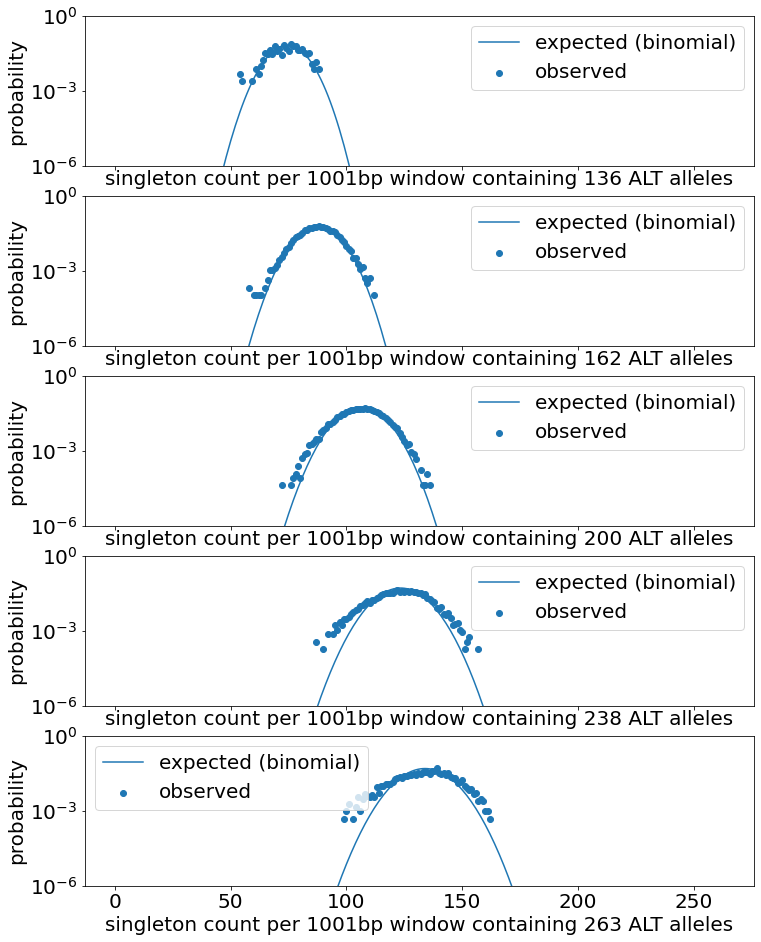

In [24]:
from scipy import stats 

def compute_mean_std_of_SNV_count():
    n = window_size # number of Bernoulli trials, each being an attempt to substitute a nucleotide 
    p = 0.2 # probability of success: typical substitution probability
    mean = n*p # (binomial) mean SNV count
    std = np.sqrt(n*p*(1-p)) # (binomial) std of SNV count
    return mean, std

def plot_singleton_count_distribution():
    mean, std = compute_mean_std_of_SNV_count()
    print(f'mean = {mean:.1f}; std = {std:.1f}')
    snv_count_to_xs_ys = {
        max(int(mean - 5*std), 1): None, 
        max(int(mean - 3*std), 1): None, 
        int(mean): None, 
        int(mean + 3*std): None,
        int(mean + 5*std): None
    }
    for snv_count, window_probabilities in model['singletonProbabilities'].items(): 
        if snv_count not in snv_count_to_xs_ys.keys(): continue 
        singleton_counts = np.arange(0, snv_count+1)
        snv_count_to_xs_ys[snv_count] = (singleton_counts, window_probabilities)
    number_rows = len(snv_count_to_xs_ys)
    fig, axes = plt.subplots(nrows=number_rows, sharex=True)
    fig.set_size_inches(12, 16)  
    for i, snv_count in enumerate(sorted(snv_count_to_xs_ys.keys())):
        xs, ys = snv_count_to_xs_ys[snv_count]
        axes[i].scatter(xs, ys, label='observed')
        axes[i].set_ylabel('probability')
        axes[i].set_xlabel(f"singleton count per {model['windowSize']}bp window containing {snv_count} ALT alleles")

        window_counts = model['singletonCounts'][snv_count]
        (
            p_hat, 
            _, 
            window_count
        ) = compute_phat_normalized_std(snv_count, window_counts)
        ys_expected = stats.binom(snv_count, p_hat).pmf(xs)
        axes[i].plot(xs, ys_expected, label='expected (binomial)')
        axes[i].legend()

        axes[i].set_ylim([1e-6, 1])
        axes[i].set_yscale('log')
        axes[i].set_xscale('linear')
    
plot_singleton_count_distribution()

The plots above show that the observed distribution gets slightly wider relative to the binomial as the number of ALT alleles in the window increases. 

## Conclusion 

By fitting a curve to the normalized mean and normalized standard deviation of singleton count (as a function of SNV count) we may obtain estimates for the mean and standard deviation of the singleton distribution for ALL SNV counts, 
including those which were not seen in the training set (putatively neutral regions). 

Clearly the estimates of the mean and standard deviation of the singleton count distribution are noisy when the number of SNVs is much smaller than or much larger than the typical SNV count. 

Given an SNV count, 
we may report an error bar for the mean and standard deviation by re-sampling the singleton count distribution, 
computing a mean and standard deviation for each re-sample. 

But for now, we simply note the values of the SNV count for which our singleton z-score is expected to be too noisy to be trusted. 